In [1]:
import os
import requests
import pandas as pd

url = 'https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz'
fname = os.path.basename(url)

if not os.path.isfile(fname):
    print(f"Downloading...\n{url}")
    r = requests.get(url, allow_redirects=True)
    open(fname, 'wb').write(r.content)
else:
    print(f"Already downloaded:\n{url}")
    
# parse the file
cols = ['source', 'target', 'rating', 'time']
df = pd.read_csv(fname, names=cols, header=None)
df['time'] = pd.to_datetime(df.time * 1e9)
df = df.set_index('time')
df.shape

Downloading...
https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz


(35592, 3)

In [2]:
'''
Code for the paper:
Edge Weight Prediction in Weighted Signed Networks. 
Conference: ICDM 2016
Authors: Srijan Kumar, Francesca Spezzano, VS Subrahmanian and Christos Faloutsos

Author of code: Srijan Kumar
Email of code author: srijan@cs.stanford.edu
'''

import networkx as nx
import math
import sys

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
fxg_G = nx.DiGraph()
edges = [(t.source, t.target, float(t.rating)/10) for t in df.itertuples()]
fxg_G.add_weighted_edges_from(edges)

print(f"Nodes: {fxg_G.number_of_nodes()}")
print(f"Edges: {fxg_G.number_of_edges()}")

Nodes: 5881
Edges: 35592


In [4]:
# edges

In [5]:
def initialize_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='weight')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness

def compute_fairness_goodness(G):
    fairness, goodness = initialize_scores(G)
    
    nodes = G.nodes()
    iter = 0
    while iter < 100:
        df = 0
        dg = 0

        # print '-----------------'
        # print "Iteration number", iter
        
        # print 'Updating goodness'
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            # print(inedges)
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        # print 'Updating fairness'
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        # print 'Differences in fairness score and goodness score = %.2f, %.2f' % (df, dg)
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    
    return fairness, goodness

# skip = int(sys.argv[1])

# G = nx.DiGraph()

# f = open("network.csv","r")
# for l in f:
#     ls = l.strip().split(",")
#     G.add_edge(ls[0], ls[1], weight = float(ls[2])) ## the weight should already be in the range of -1 to 1
# f.close()

In [6]:
# these two dictionaries have the required scores
fairness, goodness = compute_fairness_goodness(fxg_G)

In [7]:
# goodness

a1_sorted_keys = sorted(goodness, key=goodness.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, goodness[r])
    i += 1
    if (i == 10):
      break


3484 1.0
5761 0.9924160152464291
1545 0.9921592298650366
529 0.9869391400402696
5568 0.9805436843855749
3975 0.978132050478926
1663 0.9765236186774563
5438 0.972116571826292
5960 0.9573708849079442
5824 0.9535625315492423


In [8]:
a1_sorted_keys_ascending = sorted(goodness, key=goodness.get)
i = 0
for r in a1_sorted_keys_ascending:
    print(r, goodness[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys_ascending)

3665 -1.0
4182 -1.0
1211 -0.9986627190052006
1329 -0.9960090122990127
5804 -0.9840903913328286
5549 -0.9837515248941882
2530 -0.9830143667603828
5993 -0.9830143667603828
1387 -0.9810088301359629
5791 -0.9736222981778326


5881

In [9]:
a1_sorted_keys = sorted(fairness, key=fairness.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, fairness[r])
    i += 1
    if (i == 10):
      break


3 1
16 1
20 1
25 1
103 1
131 1
205 1
220 1
223 1
260 1


In [10]:
a1_sorted_keys_ascending = sorted(fairness, key=fairness.get)
i = 0
for r in a1_sorted_keys_ascending:
    print(r, fairness[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys_ascending)

5129 0.3199615714769132
5237 0.32034796466954996
2720 0.34199150984295984
1572 0.36429562972734464
2631 0.3860194480813071
5201 0.3933879789923556
5202 0.3933879789923556
4742 0.3957305463444247
5200 0.4110803529196937
2685 0.4117246163926509


5881

In [11]:
fxg = {}

for key, fair in fairness.items():
  # fxg[key] = (fair * goodness[key] + 1)/2
  # fxg[key] = 0.2 * fair + 0.8 * ((goodness[key] + 1)/2)
  fxg[key] = 0.9 * (goodness[key] + 1)/2  + 0.1 * fair

len(fxg)

a1_sorted_keys = sorted(fxg, key=fxg.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, fxg[r])
    i += 1
    if (i == 10):
      break


1545 0.9964716534392665
3975 0.9901594227155167
1663 0.9894356284048553
5960 0.980816898208575
5824 0.979103139197159
3484 0.9698185433803774
5162 0.9666333141012289
5720 0.9662537263335551
1501 0.9646103038424911
529 0.9628891496042593


In [12]:
a1_sorted_keys_ascending = sorted(fxg, key=fxg.get)
i = 0
for r in a1_sorted_keys_ascending:
    print(r, fxg[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys_ascending)

1572 0.06038721716685366
5188 0.06220279306050251
5549 0.06973717527989393
3993 0.07012909627719423
5791 0.07080833422408976
1329 0.0816971742703588
5370 0.09110166819872367
3665 0.09113053521996868
3144 0.09157219484074985
4182 0.1


5881

In [13]:
# 35 0.0157177650026555
# 2642 0.011715828938439
# 1810 0.006835762404540698
# 7 0.006524150895390367
# 2028 0.006498874234636762
# 1 0.006047911140049773
# 4172 0.005308617211409886
# 1953 0.0052821541930352265
# 905 0.005087577643047243
# 4197 0.004900944770779967

In [14]:
# 35 0.22074829931972786
# 2642 0.1391156462585034
# 1810 0.12159863945578231
# 2125 0.09812925170068026
# 2028 0.09727891156462584
# 905 0.08979591836734693
# 4172 0.08265306122448979
# 7 0.07619047619047618
# 1 0.075
# 4197 0.06887755102040816


In [15]:
# 35 0.017000361834421853
# 2642 0.013690303433432109
# 7 0.008713929882228029
# 1 0.007539877473595475
# 2028 0.006764826882160069
# 1810 0.006686569737673391
# 1953 0.006409396736348481
# 4172 0.005532398637202839
# 13 0.005228904401405083
# 1018 0.005100526936618134


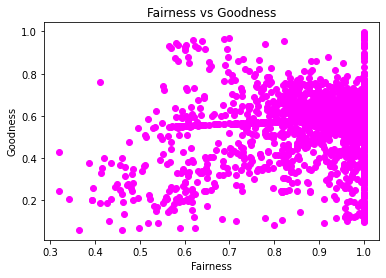

In [16]:
plt.scatter(fairness.values(), fxg.values(), color = "magenta")
plt.title("Fairness vs Goodness")
plt.xlabel("Fairness")
plt.ylabel("Goodness")
plt.show()

## Subsampling

What's the distribution of values look like month-to-month? Can we subsample to visualize a reasonable number of nodes?

In [ ]:
# ratings overview by month
df.resample('M').rating.value_counts().unstack().sample(5)

rating,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
time,,,,,,,,,,,,,,,,,,,,
2015-11-30,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,9.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2016-01-31,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,13.0,NaN,4.0,4.0,1.0,1.0,NaN,NaN,NaN
2012-03-31,11.0,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,5.0,372.0,67.0,35.0,16.0,27.0,4.0,3.0,9.0,1.0,7.0
2015-02-28,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,59.0,17.0,14.0,7.0,8.0,NaN,NaN,1.0,NaN,4.0
2011-07-31,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,371.0,75.0,38.0,9.0,15.0,3.0,2.0,3.0,2.0,17.0


In [ ]:
# later adoption years have a broader range of values
# this month has a good spread of ratings
df_ = df.loc['2014-03']
print(f"Ratings: {len(df_)}")
df_.sample(10)

Ratings: 330


,source,target,rating
time,,,
2014-03-14 09:09:53.404069888,3988,5459,1
2014-03-17 00:32:14.668459776,4611,5403,4
2014-03-09 14:34:29.079559936,4291,4867,1
2014-03-12 08:35:22.155989760,4205,3988,1
2014-03-05 07:11:00.650739968,3707,3572,1
2014-03-02 17:50:49.819650048,5353,4172,10
2014-03-14 02:28:29.658390016,3452,3714,1
2014-03-19 20:36:49.089859840,5403,3897,1
2014-03-31 15:30:46.986769920,2045,4991,-10


In [ ]:
df_35_target = df[df['target'] == 35]
df_35_target

,source,target,rating
time,,,
2010-12-21 12:52:28.103069952,65,35,2
2010-12-27 12:37:43.223400192,69,35,2
2011-01-02 19:36:31.469850112,79,35,1
2011-01-09 19:12:42.031950080,70,35,1
2011-03-09 13:57:54.432620032,7,35,2
...,...,...,...
2015-10-01 05:45:11.850800128,3804,35,1
2015-10-01 07:20:22.456029952,5983,35,3
2015-10-20 19:07:32.913500160,5993,35,1


In [ ]:
pos_df_35_target = df_35_target[df_35_target['rating'] > 0]
min(list(pos_df_35_target['rating']))

1

In [ ]:
# df_35_source = df[df['source'] == 35]
# df_35_source

In [ ]:

############## UNDIRECTED DEGREE

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
G = nx.DiGraph()
edges = [(t.source, t.target, float(t.rating)) for t in df.itertuples()]
G.add_weighted_edges_from(edges)

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Nodes: 5881
Edges: 35592


In [ ]:
# No Self Edges

count = 0
for t in df.itertuples():
  if (t.source != t.target):
    count += 1
count

35592

In [ ]:
# NO Multiedges

# cols = ['source', 'target', 'rating', 'time']
# df_new = pd.read_csv(fname, names=cols, header=None)
# df_test = df_new.drop(columns = ['time', 'rating'])
# print(df_test.head)
# # df_test.groupby(['source','target']).size().reset_index(name='Count')
# len(df_test[['source', 'target']].drop_duplicates())

In [ ]:
nx.is_weakly_connected(G)

False

In [ ]:
# list(nx.weakly_connected_components(DG))

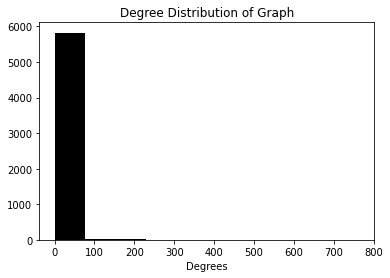

The maximum degree of Graph is: 763


In [ ]:
# Compute the degree distribution of entire graph.
degrees = [len(list(G.neighbors(n))) for n in G.nodes()]

plt.hist(degrees, color = "black")
plt.xlabel("Degrees")
plt.title("Degree Distribution of Graph")
plt.show()


print("The maximum degree of Graph is: {}" .format(max(degrees)))

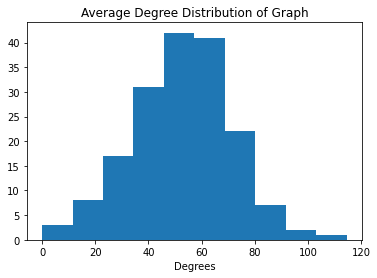

In [ ]:
avg_degree = nx.average_degree_connectivity(G)
plt.hist(avg_degree.values())
plt.xlabel("Degrees")
plt.title("Average Degree Distribution of Graph")
plt.show()

In [ ]:

############## DEGREE CENTRALITY

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

degree_G = nx.MultiDiGraph()
# G = nx.DiGraph()

In [ ]:
edges = []
for t in df.itertuples():
  tmp = t.rating + 11
  for i in range(tmp):
    edges.append((t.source, t.target, 1))

len(edges)

427532

In [ ]:
# edges = [(t.source, t.target, float(t.rating)) for t in df.itertuples()]
degree_G.add_weighted_edges_from(edges)

print(f"Nodes: {degree_G.number_of_nodes()}")
print(f"Edges: {degree_G.number_of_edges()}")

Nodes: 5881
Edges: 427532


In [ ]:
in_deg_cen = nx.in_degree_centrality(degree_G)
out_deg_cen = nx.out_degree_centrality(degree_G)

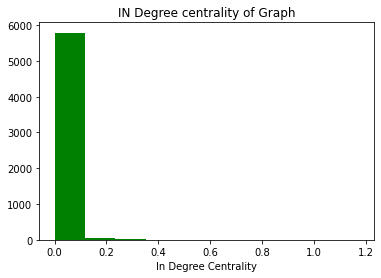

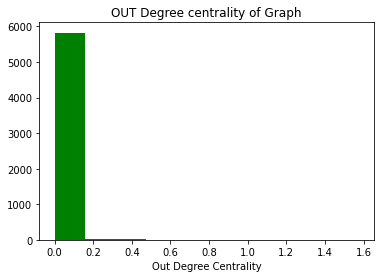

In [ ]:
# DEGREE CENTRALITY

# Use in-degree and out-degree centrality separately for directed
# Use multigraph and add edges equal to the number of edge weight (after adding 10)


# deg_cen = nx.degree_centrality(G)
# deg_cent = nx.degree_centrality(G)
# max_dc = max(list(deg_cent.values()))

# def find_nodes_with_highest_deg_cent(G):
#     deg_cent = nx.degree_centrality(G)
#     max_dc = max(list(deg_cent.values()))
#     nodes = set() 
#     for k, v in deg_cent.items():
#         if v  == max_dc:
#             nodes.add(k)
#     return nodes

plt.hist(list(in_deg_cen.values()), color = "green")
plt.title("IN Degree centrality of Graph")
plt.xlabel("In Degree Centrality")
plt.show()
plt.hist(list(out_deg_cen.values()), color = "green")
plt.title("OUT Degree centrality of Graph")
plt.xlabel("Out Degree Centrality")
plt.show()

In [ ]:
a1_sorted_keys = sorted(in_deg_cen, key=in_deg_cen.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, in_deg_cen[r])
    i += 1
    if (i == 10):
      break


35 1.1736394557823129
2642 0.9477891156462585
1810 0.6209183673469387
1 0.5590136054421768
2028 0.5562925170068027
905 0.5212585034013605
7 0.5085034013605442
4172 0.495578231292517
4197 0.4505102040816326
13 0.4153061224489796


In [ ]:
lst = []
for key, val in in_deg_cen.items():
  lst.append(val)


sum = 0
for val in lst:
  sum += val

sum

72.70952380951987

In [ ]:
# # NORMALIZE IN DEGREE CENTRALITY

# max_in_deg = max(list(in_deg_cen.values()))
# for key, val in in_deg_cen.items():
#   in_deg_cen[key] /= max_in_deg

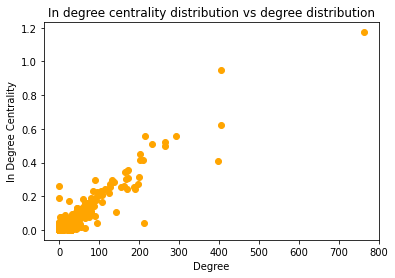

In [ ]:
plt.scatter(degrees, list(in_deg_cen.values()), color = "orange")
plt.title("In degree centrality distribution vs degree distribution")
plt.xlabel("Degree")
plt.ylabel("In Degree Centrality")
plt.show()

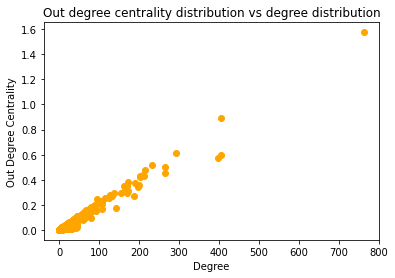

In [ ]:
plt.scatter(degrees, list(out_deg_cen.values()), color = "orange")
plt.title("Out degree centrality distribution vs degree distribution")
plt.xlabel("Degree")
plt.ylabel("Out Degree Centrality")
plt.show()

In [ ]:

################ BETWEEN-NESS CENTRALITY


%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
between_G = nx.DiGraph()

# For weighted graphs the edge weights must be greater than zero. 
# Zero edge weights can produce an infinite number of equal length 
# paths between pairs of nodes.

# Thus we add 11 here -- no difference because ranking would be relative
edges = [(t.source, t.target, 1/(float(t.rating)+11)) for t in df.itertuples()]
between_G.add_weighted_edges_from(edges)

print(f"Nodes: {between_G.number_of_nodes()}")
print(f"Edges: {between_G.number_of_edges()}")

Nodes: 5881
Edges: 35592


In [ ]:
# Normalize the centrality scores with the factor
# so that the score represents the probability that 
# a traveler along a shortest path between two random
# nodes will travel through a given node.

bet_cen = nx.betweenness_centrality(between_G, weight='weight', normalized = True)
print("Maximum vaule of Betweenness Centrality is: {}" .format(max(bet_cen.values())))

Maximum vaule of Betweenness Centrality is: 0.14101756050921535


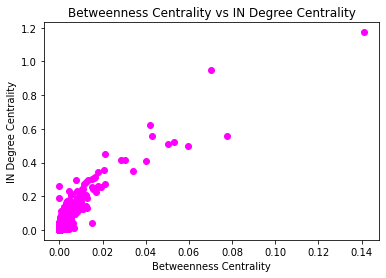

In [ ]:
plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
plt.title("Betweenness Centrality vs IN Degree Centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("IN Degree Centrality")
plt.show()

In [ ]:
# Closeness Centrality

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
close_G = nx.DiGraph()

# For weighted graphs the edge weights must be greater than zero. 
# Zero edge weights can produce an infinite number of equal length 
# paths between pairs of nodes.

# Thus we add 11 here -- no difference because ranking would be relative
edges = [(t.source, t.target, 100/(float(t.rating)+11)) for t in df.itertuples()]
close_G.add_weighted_edges_from(edges)

print(f"Nodes: {close_G.number_of_nodes()}")
print(f"Edges: {close_G.number_of_edges()}")

Nodes: 5881
Edges: 35592


In [ ]:
# If the ‘distance’ keyword is set to an edge attribute key then the shortest-path
# length will be computed using Dijkstra’s algorithm with that edge attribute as 
# the edge weight.

# The closeness centrality is normalized to (n-1)/(|G|-1) where n is the number of
# nodes in the connected part of graph containing the node. If the graph is not 
# completely connected, this algorithm computes the closeness centrality for each
# connected part separately.

# The closeness centrality uses inward distance to a node, not outward. If you 
# want to use outword distances apply the function to G.reverse()

# incloseness
in_close_centrality = nx.closeness_centrality(close_G, distance='weight')
print("Maximum vaule of IN Closeness Centrality is: {}" .format(max(in_close_centrality.values())))

Maximum vaule of IN Closeness Centrality is: 0.04352263549576469


In [ ]:
# out_close_centrality = nx.closeness_centrality(close_G, distance='weight')
# print("Maximum vaule of OUT Closeness Centrality is: {}" .format(max(out_close_centrality.values())))

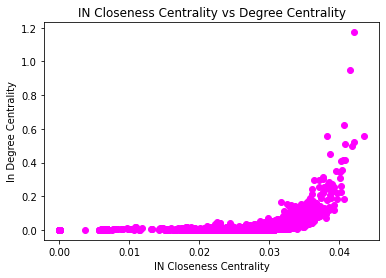

In [ ]:
plt.scatter(in_close_centrality.values(), in_deg_cen.values(), color = "magenta")
plt.title("IN Closeness Centrality vs Degree Centrality")
plt.xlabel("IN Closeness Centrality")
plt.ylabel("In Degree Centrality")
plt.show()

In [ ]:
################ PAGERANK

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
pagerank_G = nx.DiGraph()
edges = [(t.source, t.target, (float(t.rating) + 11)) for t in df.itertuples()]
pagerank_G.add_weighted_edges_from(edges)

print(f"Nodes: {pagerank_G.number_of_nodes()}")
print(f"Edges: {pagerank_G.number_of_edges()}")
regular_pagerank = nx.pagerank(pagerank_G, weight="weight")


# edges


Nodes: 5881
Edges: 35592


In [ ]:
len(regular_pagerank)

5881

In [ ]:
a1_sorted_keys = sorted(regular_pagerank, key=regular_pagerank.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, regular_pagerank[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys)

35 0.015562676951574076
2642 0.011608916912107713
1810 0.007018449608213649
2028 0.006529697827152972
7 0.006438760857046882
1 0.005935553099260284
4172 0.005286672711178072
1953 0.0052727994926984245
905 0.005211466175258825
4197 0.004926107238422774


5881

In [ ]:
a1_sorted_keys_ascending = sorted(regular_pagerank, key=regular_pagerank.get)
i = 0
for r in a1_sorted_keys_ascending:
    print(r, regular_pagerank[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys_ascending)

253 3.455060430861033e-05
1072 3.455060430861033e-05
1567 3.455060430861033e-05
1742 3.455060430861033e-05
2218 3.455060430861033e-05
2418 3.455060430861033e-05
2855 3.455060430861033e-05
2938 3.455060430861033e-05
3282 3.455060430861033e-05
3386 3.455060430861033e-05


5881

In [ ]:
# 1572 5.247771858181233e-06
# 5188 5.9307163086418325e-06
# 3993 6.560323868663791e-06
# 5791 7.157996764994988e-06
# 5549 7.320872549386841e-06
# 5738 7.727504551906595e-06
# 3144 7.75094330745207e-06
# 5370 7.854642308528725e-06
# 1329 8.995656096178835e-06
# 5036 9.57082267390646e-06

# 4182 0.0
# 1211 4.260502521637183e-08
# 5804 5.06871241783518e-07
# 2530 5.411527833748337e-07
# 1387 6.050480595270152e-07
# 2209 1.0979714973171683e-06
# 3372 1.2734479707689684e-06
# 3866 1.3980373511983898e-06
# 5547 1.5116947458943564e-06
# 1705 1.5380358821570281e-06
# 5881

# 4182 0.0
# 1211 4.260502521637183e-08
# 5804 5.06871241783518e-07
# 2530 5.411527833748337e-07
# 1387 6.050480595270152e-07
# 2209 1.0979714973171683e-06
# 3372 1.2734479707689684e-06
# 3866 1.3980373511983898e-06
# 5547 1.5116947458943564e-06
# 1705 1.5380358821570281e-06
# 5881



In [ ]:
# new = dict(sorted(regular_pagerank.items(), key=lambda item: item[1]), reverse=True)
# sum = 0
# for key, val in new.items():
#   sum += val


lst = []
for key, val in regular_pagerank.items():
  lst.append(val)


# sum

In [ ]:
lst = []
for key, val in regular_pagerank.items():
  lst.append(val)


sum = 0
for val in lst:
  sum += val

sum

0.9999999999999967

In [ ]:
len(lst)

5881

In [ ]:
def initialize_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='weight')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness

def compute_fairness_goodness(G):
    fairness, goodness = initialize_scores(G)
    
    nodes = G.nodes()
    iter = 0
    while iter < 100:
        df = 0
        dg = 0

        # print '-----------------'
        # print "Iteration number", iter
        
        # print 'Updating goodness'
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            # print(inedges)
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        # print 'Updating fairness'
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        # print 'Differences in fairness score and goodness score = %.2f, %.2f' % (df, dg)
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    
    return fairness, goodness

# skip = int(sys.argv[1])

# G = nx.DiGraph()

# f = open("network.csv","r")
# for l in f:
#     ls = l.strip().split(",")
#     G.add_edge(ls[0], ls[1], weight = float(ls[2])) ## the weight should already be in the range of -1 to 1
# f.close()

In [ ]:
# these two dictionaries have the required scores
fairness, goodness = compute_fairness_goodness(fxg_G)

In [ ]:
fxg = {}

for key, fair in fairness.items():
  # fxg[key] = (fair * goodness[key] + 1)/2
  # fxg[key] = 0.2 * fair + 0.8 * ((goodness[key] + 1)/2)
  fxg[key] = (goodness[key] + 1)/2

len(fxg)

a1_sorted_keys = sorted(fxg, key=fxg.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, fxg[r])
    i += 1
    if (i == 10):
      break


3484 1.0
5761 0.9962080076232145
1545 0.9960796149325183
529 0.9934695700201348
5568 0.9902718421927874
3975 0.989066025239463
1663 0.9882618093387281
5438 0.9860582859131459
5960 0.9786854424539722
5824 0.9767812657746211


In [ ]:
################ PAGERANK

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
pagerank_G = nx.DiGraph()
edges = [(t.source, t.target, (float(t.rating) + 11)) for t in df.itertuples()]
pagerank_G.add_weighted_edges_from(edges)

print(f"Nodes: {pagerank_G.number_of_nodes()}")
print(f"Edges: {pagerank_G.number_of_edges()}")
regular_pagerank = nx.pagerank(pagerank_G, weight="weight")


# edges


Nodes: 5881
Edges: 35592


In [ ]:
def personalizedPagerank(G,d=0.15,personalization=None,max_iter=100,tol=1.0e-6,weight="weight"):
    if len(G) == 0:
        return {}

    degree = dict(G.out_degree(weight=weight))
    for u, v, d in G.edges(data=True):
        if degree[u] == 0:
            d[weight] = 0
        else:
            d[weight] = d.get(weight, 1) / degree[u]

    N = G.number_of_nodes()
    x = dict.fromkeys(G, 1.0 / N)

    s = float(sum(personalization.values()))
    personalized_weights = {k: v / s for k, v in personalization.items()}
    dangling_nodes = [n for n in G if G.out_degree(n, weight=weight) == 0.0]

    ###################### power iteration method
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = (1-d) * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            for _, nbr, wt in G.edges(n, data=weight):
                x[nbr] += (1-d) * xlast[n] * wt
            x[n] += danglesum * personalized_weights.get(n, 0) + (1.0 - (1-d)) * personalized_weights.get(n, 0)
        err = sum(abs(x[n] - xlast[n]) for n in x)
        if err < N * tol:
            return x

    return "Failed to converge within" + str(max_iter) + "iterations"

In [ ]:
impl_pagerank = personalizedPagerank(pagerank_G, personalization=fxg, max_iter =  100)

In [ ]:
a1_sorted_keys = sorted(impl_pagerank, key=impl_pagerank.get, reverse=True)
i = 0

top_5 = {}

for r in a1_sorted_keys:
    top_5[(r, i)] = []
    print(r, impl_pagerank[r])
    i += 1
    if (i == 5):
      break

len(a1_sorted_keys)

35 0.015751152134052815
2642 0.011829600135701817
1810 0.006879462766462538
7 0.0066598384568134755
2028 0.006559777874597095


5881

In [ ]:
# 35 0.015751152134052766
# 2642 0.011829600135701812
# 1810 0.006879462766462538
# 7 0.006659838456813474
# 2028 0.006559777874597094




In [ ]:
# 35 0.015751152134052697
# 2642 0.011829600135701735
# 1810 0.006879462766462496
# 7 0.006659838456813436
# 2028 0.006559777874597053
# 5881

top_5

{(7, 3): [], (35, 0): [], (1810, 2): [], (2028, 4): [], (2642, 1): []}

In [ ]:
a1_sorted_keys_ascending = sorted(personalized_pagerank, key=personalized_pagerank.get)
i = 0
for r in a1_sorted_keys_ascending:
    print(r, personalized_pagerank[r])
    i += 1
    if (i == 5):
      break

len(a1_sorted_keys_ascending)

5188 4.968884821459735e-06
3993 5.518147817491278e-06
1572 6.221030109017299e-06
3144 6.865522525548562e-06
5993 7.58172666510387e-06


5881

In [ ]:
top_node = []
top_score = []
i=0
for r in a1_sorted_keys:
    # print(r, personalized_pagerank[r])
    top_node.append(r)
    top_score.append(personalized_pagerank[r])
    i += 1
    if (i == 5):
      break

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Node ID', 'Score']),
                 cells=dict(values=[ top_node, top_score]))
                     ])

fig.update_layout(
    # title="Fig. 3.2 - Curve Fitting in Total Cases per Million Population vs Human Development Index",
    # xaxis_title="Stringency Index",
    # yaxis_title="Total Cases per Million Population",
    # legend_title="Legend Title",
    # template="plotly_dark",
    width=380, height=130,
    margin=dict(l=0, r=0, t=0, b=0),
    # showlegend=False
)
fig.show()


In [ ]:
top_node = []
top_score = []
i=0
for r in a1_sorted_keys_ascending:
    # print(r, personalized_pagerank[r])
    top_node.append(r)
    top_score.append(personalized_pagerank[r])
    i += 1
    if (i == 5):
      break

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Node ID', 'Score']),
                 cells=dict(values=[ top_node, top_score]))
                     ])fig.update_layout(
    # title="Fig. 3.2 - Curve Fitting in Total Cases per Million Population vs Human Development Index",
    # xaxis_title="Stringency Index",
    # yaxis_title="Total Cases per Million Population",
    # legend_title="Legend Title",
    # template="plotly_dark",
    width=380, height=130,
    margin=dict(l=0, r=0, t=0, b=0),
    # showlegend=False
)
fig.show()


In [ ]:
lst = []
for key, val in personalized_pagerank.items():
  lst.append(val)


sum = 0
for val in lst:
  sum += val

sum

0.9999999999999959

In [ ]:
min(lst)

9.4359267082037e-06

In [ ]:
################ Eigen

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

# DG = nx.MultiDiGraph()
eigen_G = nx.DiGraph()
edges = [(t.source, t.target, (float(t.rating) + 11)) for t in df.itertuples()]
eigen_G.add_weighted_edges_from(edges)

print(f"Nodes: {eigen_G.number_of_nodes()}")
print(f"Edges: {eigen_G.number_of_edges()}")
# result = nx.pagerank(eigen_G, weight="weight")


# edges


Nodes: 5881
Edges: 35592


In [ ]:
# For directed graphs this is "left" eigenvector centrality which corresponds
#     to the in-edges in the graph. For out-edges eigenvector centrality
#     first reverse the graph with G.reverse().

# For directed graphs, we can use the Eigen Vector centrality to evaluate
# the “importance” of a node (based on the out-degree Eigen Vector) and
# the “prestige” of a node (through the in-degree Eigen Vector)

left_eigen_centrality = nx.eigenvector_centrality(eigen_G, weight = 'weight')

In [ ]:
right_eigen_centrality = nx.eigenvector_centrality(eigen_G.reverse(), weight = 'weight')

In [ ]:
# left_eigen_centrality

In [ ]:
a1_sorted_keys = sorted(right_eigen_centrality, key=right_eigen_centrality.get, reverse=True)
i = 0
for r in a1_sorted_keys:
    print(r, right_eigen_centrality[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys)

2642 0.20350191094320688
905 0.18894194670019895
2028 0.16272680668786954
4291 0.1518854192144229
1810 0.14779110400996923
35 0.14631178789821572
4172 0.14032011536979958
1 0.1343415190446668
1018 0.12980414778584481
13 0.128453782180725


5881

In [ ]:
a1_sorted_keys_ascending = sorted(right_eigen_centrality, key=right_eigen_centrality.get)
i = 0
for r in a1_sorted_keys_ascending:
    print(r, right_eigen_centrality[r])
    i += 1
    if (i == 10):
      break

len(a1_sorted_keys_ascending)

3 5.320647019530772e-41
16 5.320647019530772e-41
20 5.320647019530772e-41
25 5.320647019530772e-41
103 5.320647019530772e-41
131 5.320647019530772e-41
205 5.320647019530772e-41
220 5.320647019530772e-41
223 5.320647019530772e-41
260 5.320647019530772e-41


5881

In [ ]:
# # RIGHT or OUT_EDGES

# a1_sorted_keys = sorted(right_eigen_centrality, key=right_eigen_centrality.get, reverse=True)
# i = 0
# for r in a1_sorted_keys:
#     print(r, right_eigen_centrality[r])
#     i += 1
#     if (i == 10):
#       break

# len(a1_sorted_keys)

In [ ]:
# a1_sorted_keys_ascending = sorted(right_eigen_centrality, key=right_eigen_centrality.get)
# i = 0
# for r in a1_sorted_keys_ascending:
#     print(r, right_eigen_centrality[r])
#     i += 1
#     if (i == 10):
#       break

# len(a1_sorted_keys_ascending)

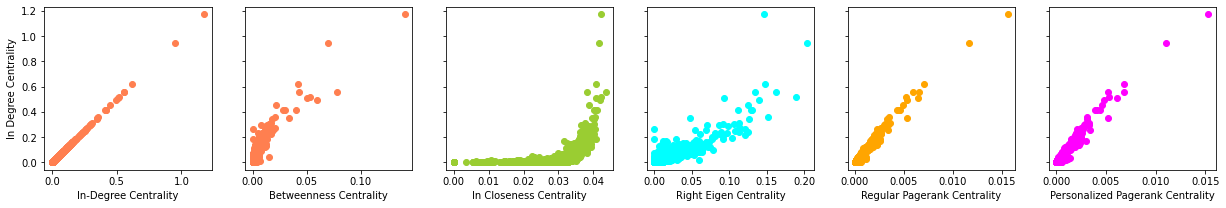

In [ ]:

#################### Correlation Matrix Plot --- 6x5
import matplotlib.pyplot as plt
import numpy as np

# In degree centrality

fig, axs = plt.subplots(1, 6, figsize=(21, 3))
# fig.suptitle('Correlation Scatter Plots against In degree Centrality measure', fontsize=16)

axs[0].scatter(in_deg_cen.values(), in_deg_cen.values(), color='coral')
# z = np.polyfit(list(in_deg_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[0].plot(list(in_deg_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[0].set(xlabel='In-Degree Centrality')

axs[1].scatter(bet_cen.values(), in_deg_cen.values(), color='coral')
# z = np.polyfit(list(bet_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[1].plot(list(bet_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[1].set(xlabel='Betweenness Centrality')

axs[2].scatter(in_close_centrality.values(), in_deg_cen.values(), color='yellowgreen')
# z = np.polyfit(list(in_close_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[2].plot(list(in_close_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[1].set_title('Axis [1]')
axs[2].set(xlabel='In Closeness Centrality')

axs[3].scatter(right_eigen_centrality.values(), in_deg_cen.values(), color='cyan')
# z = np.polyfit(list(right_eigen_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[3].plot(list(right_eigen_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[2].set_title('Axis [2]')
axs[3].set(xlabel='Right Eigen Centrality')

axs[4].scatter(regular_pagerank.values(), in_deg_cen.values(), color='orange')
# z = np.polyfit(list(regular_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[4].plot(list(regular_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[3].set_title('Axis [3]')
axs[4].set(xlabel='Regular Pagerank Centrality')

axs[5].scatter(personalized_pagerank.values(), in_deg_cen.values(), color='magenta')
# z = np.polyfit(list(personalized_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[5].plot(list(personalized_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[4].set_title('Axis [4]')
axs[5].set(xlabel='Personalized Pagerank Centrality')

# plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
# plt.title("Betweenness Centrality vs IN Degree Centrality")
# plt.xlabel("Betweenness Centrality")
# plt.ylabel("IN Degree Centrality")
# plt.show()

for ax in axs.flat:
    ax.set(ylabel='In Degree Centrality')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


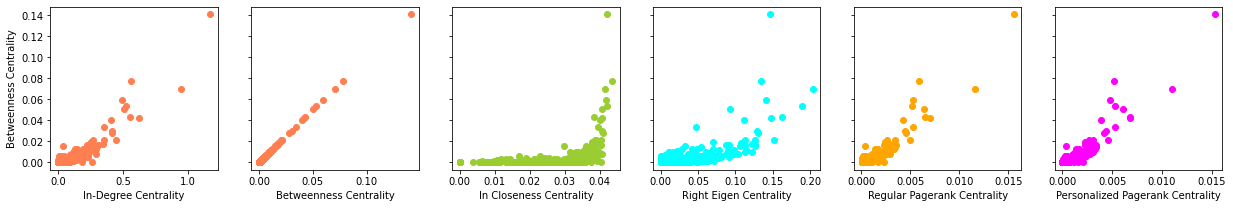

In [ ]:

#################### Correlation Matrix Plot --- 6x5
import matplotlib.pyplot as plt
import numpy as np

# In degree centrality

fig, axs = plt.subplots(1, 6, figsize=(21, 3))
# fig.suptitle('Correlation Scatter Plots against In degree Centrality measure', fontsize=16)

axs[0].scatter(in_deg_cen.values(), bet_cen.values(), color='coral')
# z = np.polyfit(list(in_deg_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[0].plot(list(in_deg_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[0].set(xlabel='In-Degree Centrality')

axs[1].scatter(bet_cen.values(), bet_cen.values(), color='coral')
# z = np.polyfit(list(bet_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[1].plot(list(bet_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[1].set(xlabel='Betweenness Centrality')

axs[2].scatter(in_close_centrality.values(), bet_cen.values(), color='yellowgreen')
# z = np.polyfit(list(in_close_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[2].plot(list(in_close_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[1].set_title('Axis [1]')
axs[2].set(xlabel='In Closeness Centrality')

axs[3].scatter(right_eigen_centrality.values(), bet_cen.values(), color='cyan')
# z = np.polyfit(list(right_eigen_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[3].plot(list(right_eigen_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[2].set_title('Axis [2]')
axs[3].set(xlabel='Right Eigen Centrality')

axs[4].scatter(regular_pagerank.values(), bet_cen.values(), color='orange')
# z = np.polyfit(list(regular_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[4].plot(list(regular_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[3].set_title('Axis [3]')
axs[4].set(xlabel='Regular Pagerank Centrality')

axs[5].scatter(personalized_pagerank.values(), bet_cen.values(), color='magenta')
# z = np.polyfit(list(personalized_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[5].plot(list(personalized_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[4].set_title('Axis [4]')
axs[5].set(xlabel='Personalized Pagerank Centrality')

# plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
# plt.title("Betweenness Centrality vs IN Degree Centrality")
# plt.xlabel("Betweenness Centrality")
# plt.ylabel("IN Degree Centrality")
# plt.show()

for ax in axs.flat:
    ax.set(ylabel='Betweenness Centrality')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


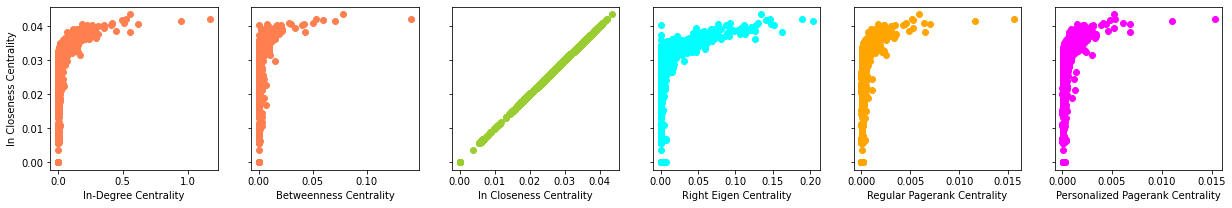

In [ ]:

#################### Correlation Matrix Plot --- 6x5
import matplotlib.pyplot as plt
import numpy as np

# In degree centrality

fig, axs = plt.subplots(1, 6, figsize=(21, 3))
# fig.suptitle('Correlation Scatter Plots against In degree Centrality measure', fontsize=16)

axs[0].scatter(in_deg_cen.values(), in_close_centrality.values(), color='coral')
# z = np.polyfit(list(in_deg_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[0].plot(list(in_deg_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[0].set(xlabel='In-Degree Centrality')

axs[1].scatter(bet_cen.values(), in_close_centrality.values(), color='coral')
# z = np.polyfit(list(bet_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[1].plot(list(bet_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[1].set(xlabel='Betweenness Centrality')

axs[2].scatter(in_close_centrality.values(), in_close_centrality.values(), color='yellowgreen')
# z = np.polyfit(list(in_close_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[2].plot(list(in_close_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[1].set_title('Axis [1]')
axs[2].set(xlabel='In Closeness Centrality')

axs[3].scatter(right_eigen_centrality.values(), in_close_centrality.values(), color='cyan')
# z = np.polyfit(list(right_eigen_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[3].plot(list(right_eigen_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[2].set_title('Axis [2]')
axs[3].set(xlabel='Right Eigen Centrality')

axs[4].scatter(regular_pagerank.values(), in_close_centrality.values(), color='orange')
# z = np.polyfit(list(regular_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[4].plot(list(regular_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[3].set_title('Axis [3]')
axs[4].set(xlabel='Regular Pagerank Centrality')

axs[5].scatter(personalized_pagerank.values(), in_close_centrality.values(), color='magenta')
# z = np.polyfit(list(personalized_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[5].plot(list(personalized_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[4].set_title('Axis [4]')
axs[5].set(xlabel='Personalized Pagerank Centrality')

# plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
# plt.title("Betweenness Centrality vs IN Degree Centrality")
# plt.xlabel("Betweenness Centrality")
# plt.ylabel("IN Degree Centrality")
# plt.show()

for ax in axs.flat:
    ax.set(ylabel='In Closeness Centrality')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


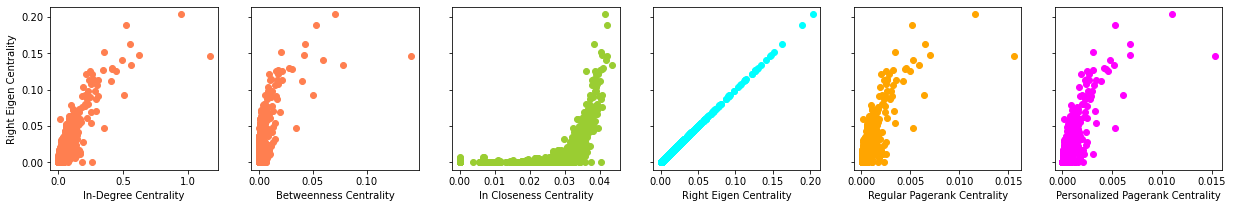

In [ ]:

#################### Correlation Matrix Plot --- 6x5
import matplotlib.pyplot as plt
import numpy as np

# In degree centrality

fig, axs = plt.subplots(1, 6, figsize=(21, 3))
# fig.suptitle('Correlation Scatter Plots against In degree Centrality measure', fontsize=16)

axs[0].scatter(in_deg_cen.values(), right_eigen_centrality.values(), color='coral')
# z = np.polyfit(list(in_deg_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[0].plot(list(in_deg_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[0].set(xlabel='In-Degree Centrality')

axs[1].scatter(bet_cen.values(), right_eigen_centrality.values(), color='coral')
# z = np.polyfit(list(bet_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[1].plot(list(bet_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[1].set(xlabel='Betweenness Centrality')

axs[2].scatter(in_close_centrality.values(), right_eigen_centrality.values(), color='yellowgreen')
# z = np.polyfit(list(in_close_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[2].plot(list(in_close_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[1].set_title('Axis [1]')
axs[2].set(xlabel='In Closeness Centrality')

axs[3].scatter(right_eigen_centrality.values(), right_eigen_centrality.values(), color='cyan')
# z = np.polyfit(list(right_eigen_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[3].plot(list(right_eigen_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[2].set_title('Axis [2]')
axs[3].set(xlabel='Right Eigen Centrality')

axs[4].scatter(regular_pagerank.values(), right_eigen_centrality.values(), color='orange')
# z = np.polyfit(list(regular_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[4].plot(list(regular_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[3].set_title('Axis [3]')
axs[4].set(xlabel='Regular Pagerank Centrality')

axs[5].scatter(personalized_pagerank.values(), right_eigen_centrality.values(), color='magenta')
# z = np.polyfit(list(personalized_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[5].plot(list(personalized_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[4].set_title('Axis [4]')
axs[5].set(xlabel='Personalized Pagerank Centrality')

# plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
# plt.title("Betweenness Centrality vs IN Degree Centrality")
# plt.xlabel("Betweenness Centrality")
# plt.ylabel("IN Degree Centrality")
# plt.show()

for ax in axs.flat:
    ax.set(ylabel='Right Eigen Centrality')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


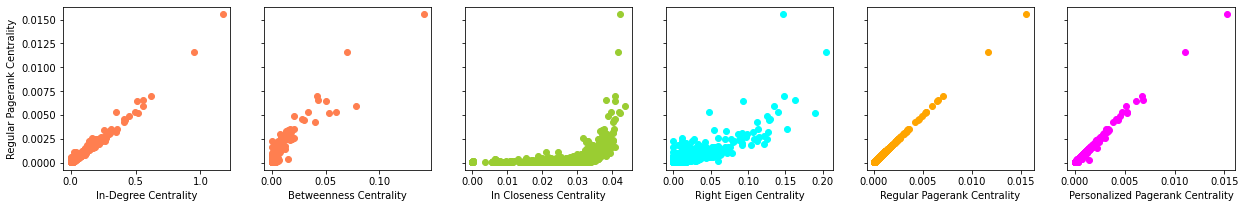

In [ ]:

#################### Correlation Matrix Plot --- 6x5
import matplotlib.pyplot as plt
import numpy as np

# In degree centrality

fig, axs = plt.subplots(1, 6, figsize=(21, 3))
# fig.suptitle('Correlation Scatter Plots against In degree Centrality measure', fontsize=16)

axs[0].scatter(in_deg_cen.values(), regular_pagerank.values(), color='coral')
# z = np.polyfit(list(in_deg_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[0].plot(list(in_deg_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[0].set(xlabel='In-Degree Centrality')

axs[1].scatter(bet_cen.values(), regular_pagerank.values(), color='coral')
# z = np.polyfit(list(bet_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[1].plot(list(bet_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[1].set(xlabel='Betweenness Centrality')

axs[2].scatter(in_close_centrality.values(), regular_pagerank.values(), color='yellowgreen')
# z = np.polyfit(list(in_close_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[2].plot(list(in_close_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[1].set_title('Axis [1]')
axs[2].set(xlabel='In Closeness Centrality')

axs[3].scatter(right_eigen_centrality.values(), regular_pagerank.values(), color='cyan')
# z = np.polyfit(list(right_eigen_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[3].plot(list(right_eigen_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[2].set_title('Axis [2]')
axs[3].set(xlabel='Right Eigen Centrality')

axs[4].scatter(regular_pagerank.values(), regular_pagerank.values(), color='orange')
# z = np.polyfit(list(regular_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[4].plot(list(regular_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[3].set_title('Axis [3]')
axs[4].set(xlabel='Regular Pagerank Centrality')

axs[5].scatter(personalized_pagerank.values(), regular_pagerank.values(), color='magenta')
# z = np.polyfit(list(personalized_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[5].plot(list(personalized_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[4].set_title('Axis [4]')
axs[5].set(xlabel='Personalized Pagerank Centrality')

# plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
# plt.title("Betweenness Centrality vs IN Degree Centrality")
# plt.xlabel("Betweenness Centrality")
# plt.ylabel("IN Degree Centrality")
# plt.show()

for ax in axs.flat:
    ax.set(ylabel='Regular Pagerank Centrality')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


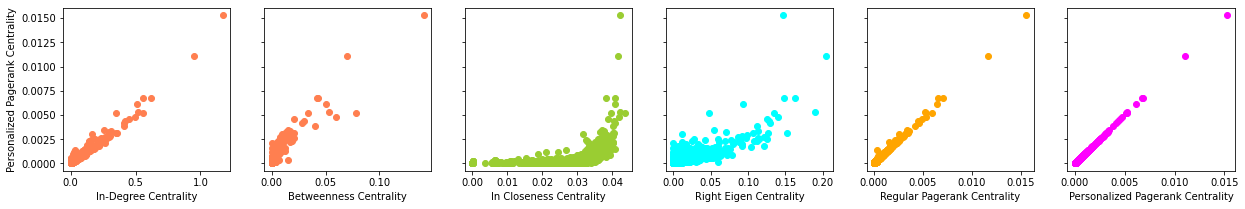

In [ ]:

#################### Correlation Matrix Plot --- 6x5
import matplotlib.pyplot as plt
import numpy as np

# In degree centrality

fig, axs = plt.subplots(1, 6, figsize=(21, 3))
# fig.suptitle('Correlation Scatter Plots against In degree Centrality measure', fontsize=16)

axs[0].scatter(in_deg_cen.values(), personalized_pagerank.values(), color='coral')
# z = np.polyfit(list(in_deg_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[0].plot(list(in_deg_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[0].set(xlabel='In-Degree Centrality')

axs[1].scatter(bet_cen.values(), personalized_pagerank.values(), color='coral')
# z = np.polyfit(list(bet_cen.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[1].plot(list(bet_cen.values()), p(list(in_deg_cen.values())),"b--")
axs[1].set(xlabel='Betweenness Centrality')

axs[2].scatter(in_close_centrality.values(), personalized_pagerank.values(), color='yellowgreen')
# z = np.polyfit(list(in_close_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[2].plot(list(in_close_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[1].set_title('Axis [1]')
axs[2].set(xlabel='In Closeness Centrality')

axs[3].scatter(right_eigen_centrality.values(), personalized_pagerank.values(), color='cyan')
# z = np.polyfit(list(right_eigen_centrality.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[3].plot(list(right_eigen_centrality.values()), p(list(in_deg_cen.values())),"b--")
# axs[2].set_title('Axis [2]')
axs[3].set(xlabel='Right Eigen Centrality')

axs[4].scatter(regular_pagerank.values(), personalized_pagerank.values(), color='orange')
# z = np.polyfit(list(regular_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[4].plot(list(regular_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[3].set_title('Axis [3]')
axs[4].set(xlabel='Regular Pagerank Centrality')

axs[5].scatter(personalized_pagerank.values(), personalized_pagerank.values(), color='magenta')
# z = np.polyfit(list(personalized_pagerank.values()), list(in_deg_cen.values()), 1)
# p = np.poly1d(z)
# axs[5].plot(list(personalized_pagerank.values()), p(list(in_deg_cen.values())),"b--")
# axs[4].set_title('Axis [4]')
axs[5].set(xlabel='Personalized Pagerank Centrality')

# plt.scatter(bet_cen.values(), in_deg_cen.values(), color = "magenta")
# plt.title("Betweenness Centrality vs IN Degree Centrality")
# plt.xlabel("Betweenness Centrality")
# plt.ylabel("IN Degree Centrality")
# plt.show()

for ax in axs.flat:
    ax.set(ylabel='Personalized Pagerank Centrality')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [ ]:
# ######### Correlation matrix

import pandas as pd

corr_df = pd.DataFrame(list(zip(in_deg_cen.values(), bet_cen.values(), in_close_centrality.values(), right_eigen_centrality.values(),
                           regular_pagerank.values(),personalized_pagerank.values() )), columns =['In-Degree', 'Betweenness', 
                                                                                                  'In-Closeness', 'Right-Eigen', 'Regular Pagerank', 'Personalized Pagerank'])


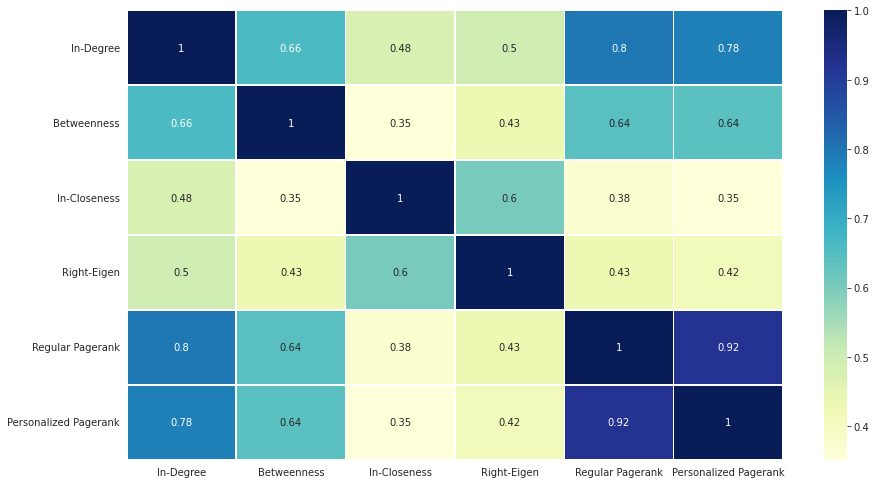

In [ ]:
import pandas as pd
from pylab import rcParams
import seaborn as sb
from scipy.stats.stats import kendalltau

# Data Visualisation Settings 
%matplotlib inline
rcParams['figure.figsize'] = 1,1
sb.set_style('whitegrid')


kendall = corr_df.corr(method='kendall')

rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(kendall, 
           xticklabels=kendall.columns.values, 
           yticklabels=kendall.columns.values, 
           cmap="YlGnBu",
           annot=True,   
           linewidth=0.5)


In [ ]:
# pearson = corr_df.corr(method='pearson')
# sb.heatmap(pearson, 
#             xticklabels=pearson.columns,
#             yticklabels=pearson.columns,
#             cmap='RdBu_r',
#             annot=True,
#             linewidth=0.5)


PLOTLY

In [ ]:
# df

# axs[1].scatter(in_close_centrality.values(), in_deg_cen.values(), color='yellowgreen')
# axs[2].scatter(left_eigen_centrality.values(), in_deg_cen.values(), color='cyan')
# axs[3].scatter(regular_pagerank.values(), in_deg_cen.values(), color='orange')
# axs[4].scatter(personalized_pagerank.values(), in_deg_cen.values(), color='magenta')

data = {'node_id':[], 'in_deg':[], 'bet':[], 'close':[], 'eigen':[],'reg_page':[], 'personalized_page':[]}

for key, val in in_deg_cen.items():
  data['node_id'].append(str(key))
  data['in_deg'].append(val)
  data['bet'].append(bet_cen[key])
  data['close'].append(in_close_centrality[key])
  data['eigen'].append(left_eigen_centrality[key])
  data['reg_page'].append(regular_pagerank[key])
  data['personalized_page'].append(personalized_pagerank[key])

df_ranks = pd.DataFrame(data)
df_ranks

,node_id,in_deg,bet,close,eigen,reg_page,personalized_page
0,6,0.092687,0.003464,0.038110,4.843614e-02,0.000838,0.000861
1,2,0.097619,0.002870,0.036129,2.464374e-02,0.001074,0.001111
2,5,0.006803,0.000000,0.032432,7.295985e-03,0.000100,0.000106
3,1,0.559014,0.077847,0.043523,1.655303e-01,0.005936,0.006092
4,15,0.027721,0.000640,0.032030,9.977704e-03,0.000336,0.000347
...,...,...,...,...,...,...,...
5876,6000,0.000000,0.000000,0.000000,5.586362e-41,0.000035,0.000032
5877,6002,0.002041,0.000000,0.000020,9.440952e-39,0.000064,0.000062
5878,6003,0.002041,0.000000,0.021489,4.223160e-05,0.000047,0.000048
5879,6004,0.002041,0.000000,0.029311,3.178789e-03,0.000052,0.000052


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly

fig = px.scatter(df_ranks, x="bet", y="in_deg",
          #  color="node_id", 
           hover_name="node_id")

# fig = px.scatter(final_df, x="stringency_index", y="case_den", trendline = "ols")
fig.update_layout(
    title="Betweenness Centrality vs In-Degree Centrality",
    xaxis_title="Betweenness Centrality",
    yaxis_title="In-Degree Centrality",
    # legend_title="COUNTRY",
    # template="plotly_dark"
)
fig.update_layout(showlegend=False)

# fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [ ]:
DG = nx.DiGraph()
edges = [(t.source, t.target, float(t.rating)) for t in df_.itertuples()]
DG.add_weighted_edges_from(edges)

print(f"Nodes: {DG.number_of_nodes()}")
print(f"Edges: {DG.number_of_edges()}")

Nodes: 211
Edges: 330


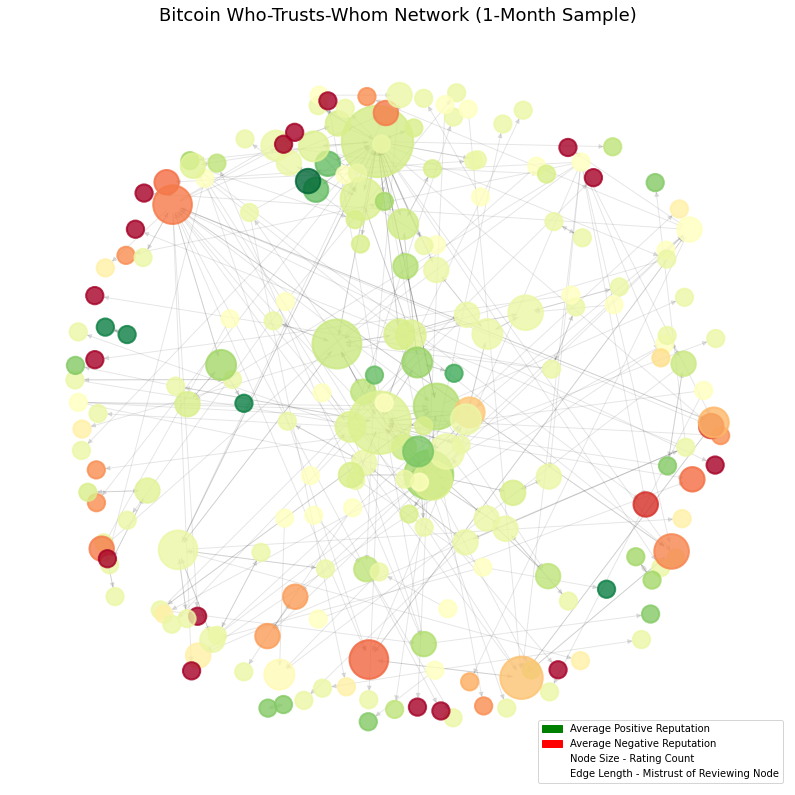

In [ ]:
# build a lookup of review counts and average trust rating
review_counts = df_.groupby('target').rating.count()
average_reviews = df_.groupby('target').rating.mean()

def get_size(user_id, m=200, min=300):
    s = review_counts.get(user_id)
    if s is not None:
        return min * s
    else:
        return min

def get_color(user_id):
    s = average_reviews.get(user_id)
    if s is None:
        return 0.5
    # need a scaling function to translate -10-10 to 0.0-1.0 for colors maps
    return np.interp(s, (-10, 10), (0, 1))

plt.figure(figsize=(14, 14)) 
plt.title("Bitcoin Who-Trusts-Whom Network (1-Month Sample)", fontsize=18)

untrusted = mpatches.Patch(color='red', label='Average Negative Reputation')
trusted = mpatches.Patch(color='green', label='Average Positive Reputation')
size = mpatches.Patch(color='white', label='Node Size - Rating Count')
edges = mpatches.Patch(color='white', label='Edge Length - Mistrust of Reviewing Node')
plt.legend(handles=[trusted, untrusted, size, edges], loc='lower right')

pos = nx.spring_layout(DG, k=0.25)
sizes = [get_size(n) for n in DG]
colors = [get_color(n) for n in DG]

nc = nx.draw_networkx_nodes(
    DG, pos, nodelist=DG.nodes(), node_size=sizes, linewidths=2.0,
    node_color=colors, cmap=plt.cm.RdYlGn, alpha=0.8
)
ec = nx.draw_networkx_edges(DG, pos, arrows=True, alpha=0.099, edge_color="black")
ax = plt.axis('off')
plt.show()